# Reinforcement Learning Fundamentals

## 🎯 The Core RL Problem

**Reinforcement Learning** is fundamentally about learning a **policy** $\pi$ that maximizes the **expected cumulative discounted reward**:

$$J(\pi) = \mathbb{E}_{\tau \sim \pi}\left[\sum_{t=0}^{\infty} \gamma^t R_t\right]$$

Where:
- $\tau = (s_0, a_0, r_1, s_1, a_1, r_2, ...)$ is a **trajectory** (sequence of states, actions, rewards)
- $\gamma \in [0,1]$ is the **discount factor** (how much we value future rewards)
- $R_t$ is the reward at time step $t$
- $\pi$ is our **policy** (strategy for choosing actions)

## 🔄 Markov Decision Process (MDP) Assumption

To make RL tractable, we assume the environment follows the **Markov Property**:

$$P(s_{t+1} | s_t, a_t, s_{t-1}, a_{t-1}, ..., s_0, a_0) = P(s_{t+1} | s_t, a_t)$$

**Translation:** *The future depends only on the present state and action, not the entire history.*

### Why This Assumption Matters

**Without the Markov assumption** (Partially Observable MDPs - POMDPs):
- We need to maintain **belief states** over possible true states
- The agent must learn to **infer hidden information** from observation history
- **Exponentially harder** - need to track probability distributions over states
- **Memory becomes crucial** - past observations help disambiguate current state
- Examples: Poker (hidden cards), autonomous driving with limited sensors

**With the Markov assumption** (Full MDPs):
- Current state contains **all relevant information** for decision making
- We can use **memoryless policies**: $\pi(a|s)$ depends only on current state
- **Mathematically tractable** - enables dynamic programming approaches
- **Most RL algorithms assume this** for computational feasibility

### MDP Components

An MDP is formally defined as a 5-tuple: $(S, A, P, R, \gamma)$

- **$S$**: State space (all possible states)
- **$A$**: Action space (all possible actions)  
- **$P(s'|s,a)$**: Transition probabilities (environment dynamics)
- **$R(s,a)$**: Reward function (immediate feedback from current state and action)
- **$\gamma$**: Discount factor (future reward weighting)

## 🎲 Policy Types

### Stochastic vs Deterministic Policies

**Stochastic Policy:** $\pi(a|s) = P(\text{action } a | \text{state } s)$
- Outputs **probability distribution** over actions
- **Natural exploration** through randomness
- Examples: Softmax policy, Gaussian policy

**Deterministic Policy:** $\pi(s) = a$
- Outputs **single action** for each state  
- Requires **external exploration** mechanisms (ε-greedy, noise)
- Examples: Greedy policy derived from learned functions

### Parameterized Policies: The Deep RL Revolution

Instead of learning a lookup table, we use **function approximation**:

$$\pi_\theta(a|s) = \text{Neural Network}(s; \theta)$$

Where $\theta$ are the **learnable parameters** (neural network weights).

#### 📚 From Classical RL to Deep RL

**Classical (Tabular) RL Era** (pre-2010s):
- **Policy Representation**: Lookup table $\pi(s) = a$ for each state
- **State Space Requirement**: Must enumerate ALL possible states
- **Feasible Environments**: 
  - GridWorld (10×10 = 100 states)
  - Tic-Tac-Toe (≈3,000 unique states)
  - Simple card games
- **Fatal Limitation**: **Curse of dimensionality** - exponential growth in state space

**Deep RL Era** (2010s-present):
- **Policy Representation**: Neural network $\pi_\theta(a|s)$ that **generalizes** across states
- **State Space Capability**: Can handle **infinite** or astronomically large state spaces
- **Feasible Environments**:
  - LunarLander: Continuous 8D observation space
  - Chess: $≈10^{47}$ possible board positions
  - Go: $≈10^{170}$ possible board positions (more than atoms in observable universe!)

#### 🚀 Why Function Approximation Changed Everything

**The Generalization Miracle:**
- A neural network trained on seeing a lander at position (0.1, 0.5) can **generalize** to position (0.11, 0.51)
- **Never seen that exact state before**, but can interpolate from similar experiences
- **Enables learning** from finite experience in infinite state spaces

## 🔧 Normalization: A Tale of Two Techniques

Normalization techniques are crucial for stabilizing deep networks, but their effectiveness in RL depends entirely on how they normalize.

### Dropout: Usually a Bad Idea ❌

In supervised learning, dropout is a powerful regularizer that prevents overfitting by randomly zeroing out neurons during training. It works by creating an ensemble of smaller networks, forcing the model to learn more robust features.

In Reinforcement Learning, however, this usually backfires:

**It Adds More Noise**: The RL learning signal is already incredibly noisy and high-variance. Dropout injects another layer of randomness directly into the policy or value function calculations. This makes the already difficult credit assignment problem even harder, as the agent's output for the exact same state is different every forward pass.

**It Creates Inconsistency**: This is especially damaging for off-policy methods. An experience stored in the replay buffer was generated with a specific dropout "mask" active. When the agent later learns from that experience, it uses a different random mask. This mismatch between the policy that acted and the policy that learns adds another layer of variance and instability, compounding the existing off-policy challenges.

Because RL agents are desperately trying to find a stable signal in a sea of noise, dropout often hurts performance by making the learning target even more chaotic.

### Batch Normalization (BatchNorm): Also a Bad Idea ❌

BatchNorm normalizes a layer's inputs based on the mean and variance of the current batch. This is highly effective when data is i.i.d. (independent and identically distributed), as in supervised learning.

In RL, this is problematic:

- **Correlated Data**: Data within an RL episode is highly correlated, not i.i.d. The statistics of one batch can be wildly different from the next.
- **Replay Buffer Issues**: For off-policy learning, the batch statistics depend entirely on what gets randomly sampled from the replay buffer. A batch of early-game states has a different statistical profile than a batch of late-game states. This makes the normalization itself a source of randomness, destabilizing the learning process.

BatchNorm's dependence on batch statistics makes it a poor fit for the non-stationary and correlated data streams in RL.

### Layer Normalization (LayerNorm): A Great Idea ✅

LayerNorm, in contrast, normalizes a layer's inputs based on the mean and variance calculated across the features within a single training sample. It completely ignores the batch.

This makes it perfectly suited for RL:

- **Batch-Independent**: Because its calculations are confined to a single sample, it is immune to the problems of small batch sizes, correlated data, and non-stationary replay buffers.
- **Deterministic Stability**: It provides a consistent, deterministic form of normalization that stabilizes the activations and gradients inside the network. This helps combat instability without introducing any new randomness.

This is why Layer Normalization (and similar batch-independent methods like GroupNorm) is widely and successfully used in modern DRL architectures, while Dropout and BatchNorm are generally avoided.

## 🏗️ Our Learning Environment: LunarLander-v3

For this entire learning series, we'll use **LunarLander-v3** exclusively. This environment provides the perfect balance of complexity and simplicity for RL education.

**Reference**: [Gymnasium Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

### Environment Specifications

#### LunarLander-v3 🚀
**Observation**: 8D vector with position, velocity, angle, angular velocity, leg ground contacts

**Action Spaces**:
- **Discrete Mode**: 4 actions [do_nothing, fire_left, fire_main, fire_right]
- **Continuous Mode**: 2D vector [main_engine, lateral_booster] with bounds [-1.0, +1.0] each

**Rewards**: Distance/speed/angle penalties, +10 per leg contact, engine costs, ±100 for outcome

### Continuous Action Space Bounds

**LunarLander-v3 Continuous Actions:**
- **Action 0 (Main Engine)**: Range [-1.0, +1.0]
  - Negative values: No effect (engine can't push upward)
  - 0.0: Engine off
  - Positive values: Throttle from 0% to 100%
- **Action 1 (Lateral Engine)**: Range [-1.0, +1.0]
  - -1.0: Full left thruster
  - 0.0: No lateral thrust
  - +1.0: Full right thruster

### Why LunarLander-v3 for RL Education?

- **Dual Action Spaces**: Perfect for testing both discrete and continuous control algorithms
- **Vector Observations**: Rich, interpretable 8D state representation perfect for learning
- **Realistic Physics**: Consistent Box2D physics provides realistic dynamics
- **Educational Value**: Classic trajectory optimization problem
- **Fast Feedback**: Clear success/failure conditions with immediate results
- **No Visual Complexity**: Focus on algorithms, not CNN architectures

# REINFORCE Algorithm: Vanilla Policy Gradients

## 🎯 Algorithm Overview

**REINFORCE** (REward Increment = Nonnegative Factor × Offset Reinforcement × Characteristic Eligibility) is the most fundamental policy gradient algorithm. It directly optimizes the policy parameters using the **policy gradient theorem**.

### Key Characteristics

- **Pure Monte Carlo Method**: Waits for complete episodes, uses full episode returns
- **No Bootstrapping**: Never uses estimates to update estimates (unlike future methods we'll see)
- **On-Policy**: Uses experience only from the current policy being learned
- **Model-Free**: Doesn't require knowledge of environment dynamics
- **Policy-Based Only**: Directly optimizes the policy, no additional function learning

## 📐 Mathematical Foundation

### The Log-Likelihood Trick: From RL to Gradients

**🔑 Key Challenge**: How do we compute gradients when our objective involves expectations over trajectories that depend on our policy parameters?

**Starting Point**: Our objective is to maximize expected return:
$$J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}\left[\sum_{t=0}^{T-1} \gamma^t r_{t+1}\right]$$

**The Problem**: The expectation is over trajectories $\tau$ sampled from $\pi_\theta$, so the sampling distribution itself depends on $\theta$!

**The Log-Likelihood Trick**: We use the mathematical identity:
$$\nabla_\theta \pi_\theta(\tau) = \pi_\theta(\tau) \nabla_\theta \log \pi_\theta(\tau)$$

This allows us to rewrite:
$$\nabla_\theta \mathbb{E}_{\tau \sim \pi_\theta}[G(\tau)] = \mathbb{E}_{\tau \sim \pi_\theta}[G(\tau) \nabla_\theta \log \pi_\theta(\tau)]$$

Where $G(\tau) = \sum_{t=0}^{T-1} \gamma^t r_{t+1}$ is the episode return.

### Complete Derivation: From Log-Likelihood to Policy Gradient

Now we'll show the complete mathematical derivation step by step.

#### Step 1: Expand the Expectation

Starting from the log-likelihood trick:
$$\nabla_\theta J(\theta) = \nabla_\theta \mathbb{E}_{\tau \sim \pi_\theta}[G(\tau)]$$

Using the definition of expectation:
$$= \nabla_\theta \int_{\tau} \pi_\theta(\tau) G(\tau) d\tau$$

Applying the product rule and log-likelihood trick:
$$= \int_{\tau} \nabla_\theta \pi_\theta(\tau) G(\tau) d\tau$$
$$= \int_{\tau} \pi_\theta(\tau) \nabla_\theta \log \pi_\theta(\tau) G(\tau) d\tau$$
$$= \mathbb{E}_{\tau \sim \pi_\theta}[G(\tau) \nabla_\theta \log \pi_\theta(\tau)]$$

#### Step 2: Expand the Trajectory Probability

A trajectory $\tau = (s_0, a_0, r_1, s_1, a_1, r_2, ..., s_{T-1}, a_{T-1}, r_T)$ has probability:

$$\pi_\theta(\tau) = p(s_0) \prod_{t=0}^{T-1} \pi_\theta(a_t|s_t) P(s_{t+1}|s_t, a_t)$$

Where:
- $p(s_0)$ is the initial state distribution
- $\pi_\theta(a_t|s_t)$ is our policy (the only part dependent on $\theta$)
- $P(s_{t+1}|s_t, a_t)$ is the environment transition probability

#### Step 3: Apply the Logarithm

Taking the logarithm of the trajectory probability:
$$\log \pi_\theta(\tau) = \log p(s_0) + \sum_{t=0}^{T-1} \log \pi_\theta(a_t|s_t) + \sum_{t=0}^{T-1} \log P(s_{t+1}|s_t, a_t)$$

#### Step 4: Compute the Gradient

Taking the gradient with respect to $\theta$:
$$\nabla_\theta \log \pi_\theta(\tau) = \nabla_\theta \log p(s_0) + \sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(a_t|s_t) + \sum_{t=0}^{T-1} \nabla_\theta \log P(s_{t+1}|s_t, a_t)$$

**Key Insight**: Only the policy terms depend on $\theta$! The initial state distribution and environment dynamics are independent of our policy parameters:

- $\nabla_\theta \log p(s_0) = 0$ (initial state distribution doesn't depend on policy)
- $\nabla_\theta \log P(s_{t+1}|s_t, a_t) = 0$ (environment dynamics don't depend on policy)

Therefore:
$$\nabla_\theta \log \pi_\theta(\tau) = \sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(a_t|s_t)$$

#### Step 5: Substitute Back into the Expectation

Substituting back into our expectation:
$$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}\left[G(\tau) \sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(a_t|s_t)\right]$$

$$= \mathbb{E}_{\tau \sim \pi_\theta}\left[\sum_{t=0}^{T-1} G(\tau) \nabla_\theta \log \pi_\theta(a_t|s_t)\right]$$

#### Step 6: Refine to Return-to-Go

Here's a subtle but important refinement. Instead of using the full episode return $G(\tau)$ for every time step, we can use the **return-to-go** $G_t$ from time $t$ onwards:

$$G_t = \sum_{k=t}^{T-1} \gamma^{k-t} r_{k+1}$$

**Why this works**: The policy gradient theorem tells us that the gradient can be computed using the return from time $t$ onwards, not the full episode return. This is because:
- Actions at time $t$ cannot affect rewards that occurred before time $t$
- The causality structure means only future rewards matter for current actions

### Policy Gradient Theorem (Final Form)

This gives us the **Policy Gradient Theorem**:

$$\nabla_\theta J(\pi_\theta) = \mathbb{E}_{\pi_\theta}\left[\sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot G_t\right]$$

Where:
- $\theta$ are the policy parameters (neural network weights)
- $G_t = \sum_{k=t}^{T-1} \gamma^{k-t} r_{k+1}$ is the **return-to-go** (cumulative future reward from time $t$)
- $\nabla_\theta \log \pi_\theta(a_t|s_t)$ is the **score function** (gradient of log-probability)

#### Mathematical Intuition: Why This Makes Sense

The policy gradient theorem has a beautiful interpretation:

$$\underbrace{\nabla_\theta \log \pi_\theta(a_t|s_t)}_{\text{Direction to increase } P(a_t|s_t)} \cdot \underbrace{G_t}_{\text{How good was this action?}}$$

**English Translation:** *"Move the policy parameters in the direction that increases the probability of actions that led to high returns, and decreases the probability of actions that led to low returns."*

**The Causality Principle**: We use $G_t$ (return from time $t$ onwards) rather than $G(\tau)$ (full episode return) because:
- **Actions affect future, not past**: Action $a_t$ can only influence rewards $r_{t+1}, r_{t+2}, ...$
- **Credit assignment**: We should only credit/blame an action for consequences that it could actually influence
- **Variance reduction**: Using $G_t$ instead of $G(\tau)$ reduces variance in gradient estimates

### 🔍 Key Mathematical Insights

1. **Model-Free Nature**: The derivation doesn't require knowing $P(s_{t+1}|s_t, a_t)$ - environment dynamics cancel out in the gradient!

2. **Score Function**: $\nabla_\theta \log \pi_\theta(a_t|s_t)$ is the **score function** from statistics - it points in the direction of steepest increase in log-probability.

3. **Unbiased Estimator**: The policy gradient theorem gives us an **unbiased estimator** of the true gradient - on average, our sample-based estimates equal the true gradient.

4. **High Variance**: While unbiased, the estimator has **high variance** because it depends on noisy episode returns $G_t$.

### Intuitive Interpretation

$$\underbrace{\nabla_\theta \log \pi_\theta(a_t|s_t)}_{\text{Direction to increase } P(a_t|s_t)} \cdot \underbrace{G_t}_{\text{How good was this action?}}$$

**English Translation:** *"Increase the probability of actions that led to high returns, decrease the probability of actions that led to low returns."*

## 🔄 RL vs Supervised Learning: A Striking Similarity

### Gradient Structures are Nearly Identical!

**Supervised Learning Gradient (Maximum Likelihood Estimation):**
$$\nabla_\theta J(\theta) = \mathbb{E}_{(x,y) \sim D_{\text{train}}}\left[\nabla_\theta \log p(y|x; \theta)\right]$$

**REINFORCE Gradient:**
$$\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta}\left[\sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot G_t\right]$$

**Key Similarities:**
- Both use **log-probability gradients** as the core update mechanism
- Both are **expectation-based** optimization procedures  
- Both adjust parameters to increase probability of "good" outcomes

### Understanding the Supervised Learning Foundation

**Maximum Likelihood Estimation (MLE) in Supervised Learning:**
- **Objective**: Maximize the likelihood of observed data: $\max_\theta \prod_{i=1}^N p(y_i|x_i; \theta)$
- **Equivalent**: Minimize negative log-likelihood: $\min_\theta -\sum_{i=1}^N \log p(y_i|x_i; \theta)$
- **I.I.D. Assumption**: Training samples $(x_i, y_i)$ are **independent and identically distributed**
- **Fixed Target**: Each sample has a known, fixed "correct" answer $y_i$

**REINFORCE as "Weighted MLE":**
- **Pseudo-Target**: Actions $a_t$ become "correct answers" **weighted by their return** $G_t$
- **No Fixed Labels**: Instead of fixed $y_i$, we have actions weighted by how good they turned out to be
- **Return as Importance**: $G_t$ tells us "how much" we should treat action $a_t$ as correct

### The Fundamental Difference: Data Control & Distribution

**Supervised Learning:**
- Data $(x,y)$ is sampled from **fixed** dataset $D_{\text{train}}$ 
- Model has **no control** over which samples it sees
- Distribution is **stationary** - same data every epoch
- **I.I.D. samples**: Each training example is independent

**Reinforcement Learning:**
- Data (trajectories) generated by **agent's own policy** $\pi_\theta$
- Agent **controls** what data it collects through its actions  
- Distribution is **non-stationary** - changes as policy improves!
- **Sequential dependence**: Each action affects future states and available data

### Why This Makes RL Much Harder

**The Challenge**: As $\theta$ changes, so does $\pi_\theta$, which changes the data distribution, which affects the gradient estimates! This creates:
- **High variance** in gradient estimates
- **Non-stationary** learning problem  
- **Exploration-exploitation** tradeoffs

## 🌪️ The Interconnected Challenges of RL

### The Vicious Cycle: Variance → Instability → Parameter Sensitivity

Reinforcement Learning's major challenges are not separate issues but deeply intertwined parts of a single, difficult problem that feeds into itself:

**1. High Variance (The Root Cause)**
- Random environments, stochastic policies, and sparse rewards create incredibly noisy learning signals
- The agent receives inconsistent and contradictory feedback from the same actions
- Gradients vary wildly from one step to the next

**2. Instability (The Direct Consequence)**  
- High variance gradients cause erratic training behavior
- Policy improvements oscillate wildly instead of progressing smoothly
- Creates the "moving target" problem - the agent chases a constantly shifting optimal policy

**3. Parameter Sensitivity (The Survival Mechanism)**
- Extreme precision required in hyperparameters to control the chaos
- Learning rate, discount factor, and exploration parameters become critical stabilizers
- Slight parameter mistuning doesn't just slow learning - it causes complete divergence

### Why REINFORCE Suffers from All Three

**REINFORCE embodies these interconnected challenges:**
- **Pure Monte Carlo**: Maximum variance from using full episode returns
- **No Variance Reduction**: No baselines or bootstrapping to stabilize learning
- **Raw Policy Gradients**: Direct exposure to all the noise in the system

### The Evolution: From REINFORCE to PPO

This is precisely why the field evolved from REINFORCE to sophisticated algorithms like PPO (Proximal Policy Optimization):

**REINFORCE (1992)** → **Actor-Critic (2000s)** → **PPO (2017)**

Each step addresses the interconnected challenges:
- **Baselines** reduce variance
- **Bootstrapping** stabilizes learning  
- **Clipping** prevents destructive updates
- **Multiple epochs** improve sample efficiency

**Coming Up**: In our next notebooks, we'll see how each algorithm systematically tackles these fundamental RL challenges, building up to PPO's elegant solution that finally makes policy gradient methods stable and practical.

## 🔄 REINFORCE Algorithm

**Algorithm 1: REINFORCE**

---
**Input:** 
- Policy $\pi_\theta$ with parameters $\theta$
- Learning rate $\alpha$
- Discount factor $\gamma$
- Number of episodes $N$

**Output:** 
- Trained policy parameters $\theta$

---
**Procedure:**
1. **Initialize** policy parameters $\theta$ randomly
2. **For** $i = 1, 2, ..., N$ **do:**
3. &nbsp;&nbsp;&nbsp;&nbsp;**Generate trajectory** $\tau = (s_0, a_0, r_1, s_1, a_1, r_2, ..., s_{T-1}, a_{T-1}, r_T)$ using policy $\pi_\theta$
4. &nbsp;&nbsp;&nbsp;&nbsp;**For** $t = 0, 1, ..., T-1$ **do:**
5. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Calculate return-to-go:** $G_t \leftarrow \sum_{k=t}^{T-1} \gamma^{k-t} r_{k+1}$
6. &nbsp;&nbsp;&nbsp;&nbsp;**End For**
7. &nbsp;&nbsp;&nbsp;&nbsp;**Calculate policy gradient:** $g \leftarrow \sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot G_t$
8. &nbsp;&nbsp;&nbsp;&nbsp;**Update parameters:** $\theta \leftarrow \theta + \alpha \cdot g$
9. **End For**

---

### 🔧 Implementation Detail: Gradient Ascent vs Descent

**⚠️ PyTorch Implementation Note**: The algorithm above shows **gradient ascent** (step 8: $\theta \leftarrow \theta + \alpha \cdot g$) because we want to **maximize** the expected return $J(\pi_\theta)$.

However, **PyTorch optimizers perform gradient descent** (minimization) by default. To convert our maximization problem to minimization, we use a simple trick:

$$\max_\theta J(\pi_\theta) \equiv \min_\theta (-J(\pi_\theta))$$

## ⚠️ The Variance Problem & Return Normalization

### The Core Challenge: Extremely High Variance

**REINFORCE's Achilles' Heel**: The biggest obstacle to successful learning is the **enormous variance** in gradient estimates. This variance makes learning unstable and sample-inefficient.

**Why Variance Destroys Learning:**
- **Inconsistent Updates**: Same state-action pairs receive wildly different gradient signals
- **Noisy Progress**: Training curves look chaotic rather than smooth improvement
- **Poor Sample Efficiency**: Need many more episodes to average out the noise
- **Unstable Convergence**: Algorithm may never converge to good solutions

### 📊 Return Normalization: A Simple Stability Technique

**The Simple Trick**: In our REINFORCE implementation, we normalize the returns before computing gradients:

```python
returns_normalized = (returns - returns.mean()) / (returns.std() + 1e-8)
```

#### Why Return Normalization Helps

**The Problem**: Raw returns in LunarLander vary dramatically:
- **Successful Landing**: Returns ≈ +200 to +300
- **Crash Landing**: Returns ≈ -100 to -200
- **Hovering/Timeout**: Returns ≈ -50 to +50

**Without Normalization**:
```
Episode 1: G_t = [250, 240, 220, ...]  → Large positive gradients
Episode 2: G_t = [-150, -140, -130, ...] → Large negative gradients
Episode 3: G_t = [180, 170, 160, ...]  → Medium positive gradients
```

**With Normalization**:
```
Episode 1: G_t_norm = [1.2, 0.8, 0.3, ...]   → Consistent magnitude
Episode 2: G_t_norm = [-1.1, -0.9, -0.6, ...] → Consistent magnitude  
Episode 3: G_t_norm = [0.9, 0.5, 0.1, ...]   → Consistent magnitude
```

#### Mathematical Justification

**Key Insight**: The **relative ordering** of returns matters more than their absolute values!

**Before Normalization**: 
$$\nabla_\theta J(\theta) = \mathbb{E}\left[\sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot G_t\right]$$

**After Normalization**:
$$\nabla_\theta J(\theta) = \mathbb{E}\left[\sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot \frac{G_t - \mu_G}{\sigma_G}\right]$$

Where $\mu_G$ and $\sigma_G$ are the mean and standard deviation of returns in the current episode.

#### Benefits of Return Normalization

1. **Consistent Gradient Magnitudes**: Updates have similar scales across episodes
2. **Relative Importance Preserved**: Actions that are relatively better still get stronger positive signals
3. **Reduced Variance**: Extreme return values are tempered
4. **Stable Learning**: Less likely to have destructively large updates
5. **Better Convergence**: More consistent progress toward optimal policy

## 🎲 Handling Different Action Spaces

For REINFORCE to work, we need to be able to compute $\log \pi_\theta(a|s)$. How we do this depends on the action space.

### Discrete Action Space (`continuous=False`)

- **Action Space**: A finite set of actions: [do_nothing, fire_left, fire_main, fire_right]
- **Policy Network Output**: The network outputs **logits**, one for each possible action.
- **Probability Distribution**: We apply a **Softmax** function to the logits to create a probability distribution over actions.
  $$\pi_\theta(a|s) = \text{Softmax}(\text{logits})_a = \frac{\exp(\text{logit}_a)}{\sum_{a'} \exp(\text{logit}_{a'})}$$
- **Action Sampling**: We sample an action from this categorical distribution.
- **Log-Probability**: The log-probability is computed directly from the categorical distribution, which is computationally straightforward.

### Continuous Action Space (`continuous=True`)

- **Action Space**: A 2D vector [main_engine, lateral_booster] with bounds [-1.0, +1.0] each
- **Policy Network Output**: The network outputs the **mean** ($\mu_\theta(s)$) for a Gaussian distribution for each action dimension. We often use a fixed or learnable standard deviation ($\sigma$).
- **Probability Distribution**: We model the policy as a **Gaussian (Normal) distribution** for each action dimension.
  $$\pi_\theta(a|s) = \mathcal{N}(a; \mu_\theta(s), \sigma^2)$$
- **Action Sampling**: We sample an action vector from this multi-variate Gaussian distribution.
- **Log-Probability**: The log-probability is the log-pdf of the Gaussian distribution evaluated at the sampled action.
- **Action Clipping**: Since the environment has action bounds ([-1, 1] for each dimension), the sampled actions from the unbounded Gaussian distribution must be clipped before being sent to the environment.

## ⚡ Advantages and Disadvantages

### ✅ Advantages

1. **Conceptual Simplicity**: Pure policy optimization, easy to understand
2. **Unbiased Estimates**: Uses actual returns, no approximation bias
3. **Action Space Flexibility**: Works perfectly with LunarLander's dual action modes
4. **Stochastic Policy**: Natural exploration through policy randomness
5. **Convergence Guarantees**: Guaranteed to converge to local optimum (under conditions)

### ❌ Disadvantages

1. **🔥 HUGE VARIANCE**: Monte Carlo estimates have extremely high variance
   - **LunarLander Impact**: Episode scores range from -100 (crash) to 300+ (perfect landing)
   - **Symptom**: Training curves look like noise, very unstable learning
   - **Learning Difficulty**: Same action taken with slight timing differences gives vastly different returns
2. **Sample Inefficiency**: Must complete entire episodes before any learning
3. **No Credit Assignment**: All actions in episode get same return signal
4. **Local Optima**: Gradient ascent only finds local maxima

In [1]:
import numpy as np
import torch
import torch.optim as optim
from collections import deque
import time
from tqdm import tqdm

# Import our RL utilities
from rl_utils import (
    set_seeds,
    PolicyNetwork,
    create_env_with_wrappers,
    plot_training_results,
    plot_variance_analysis,
)

# Create configuration
CONFIG = {
    "seed": 42,
    "episodes": 1000,
    "gamma": 0.99,
    "lr": 5e-4,
    "device": "cuda",
    "window_length": 100,
    "target_score": 200,  # LunarLander-v3 target score
    # Environment: LunarLander-v3 only
    "env_id": "LunarLander-v3",
    "env_kwargs": {
        "gravity": -10.0,
        "enable_wind": False,
        "wind_power": 15.0,
        "turbulence_power": 1.5,
    },
    # Video Recording Config
    "record_videos": True,
    "video_folder": "videos",
    "num_videos": 9,  # Number of videos to record during training
    "record_test_videos": True,
    # Neural Network Config
    "policy_network": {
        "fc_out_features": [64, 64 ,64],
        "activation": "SiLU",
        "use_layer_norm": True,
        "dropout_rate": 0.0,
    },
}

set_seeds(CONFIG["seed"])
print(f"🎲 Global random seeds set to {CONFIG['seed']} for reproducible results")
print(
    f"📝 Environment episodes will use seeds {CONFIG['seed']} + episode_number for varied but reproducible episodes"
)

🎲 Global random seeds set to 42 for reproducible results
📝 Environment episodes will use seeds 42 + episode_number for varied but reproducible episodes


In [2]:
class ReinforceAgent:
    """REINFORCE agent containing the policy and update logic."""

    def __init__(self, policy_network, config):
        self.policy = policy_network.to(config["device"])
        self.optimizer = optim.Adam(self.policy.parameters(), lr=config["lr"])
        self.gamma = config["gamma"]
        self.device = config["device"]
        self.window_size = config.get("window_length")

        # Print detailed network information including parameter count
        print(f"📊 POLICY NETWORK DETAILS:")
        self.policy.print_network_info()

        # Episode-specific storage
        self.log_probs = []
        self.rewards = []

        # Gradient tracking for variance analysis
        self.gradient_norms = []
        self.episode_returns = []
        self.return_variance_history = []

        # Update step tracking - separate from episode numbers
        self.update_step = 0
        self.update_steps_history = (
            []
        )  # Track which update step each loss/gradient corresponds to

        # Loss component tracking for future algorithms
        self.loss_history = {
            "policy_loss": [],
            "total_loss": [],  # For REINFORCE, total_loss == policy_loss
        }

    def select_action(self, state):
        """Select an action from the policy distribution."""
        # Normalize observation before feeding to network

        state = torch.as_tensor(state, dtype=torch.float32, device=self.device)

        dist = self.policy(state)
        action = dist.sample()

        if self.policy.is_continuous:
            log_prob = dist.log_prob(action).sum(-1)
            # Use the policy network's clip_action method for proper bounds
            action_to_env = self.policy.clip_action(action).flatten()
        else:
            log_prob = dist.log_prob(action)
            action_to_env = action.item()

        self.log_probs.append(log_prob)
        return action_to_env

    def update_policy(self):
        """Update the policy network using the collected episode data."""
        if not self.log_probs:
            return {"policy_loss": 0.0, "total_loss": 0.0}, 0.0

        # Increment update step counter
        self.update_step += 1

        # 1. Calculate discounted returns (G_t)
        returns = []
        discounted_reward = 0
        for r in reversed(self.rewards):
            discounted_reward = r + self.gamma * discounted_reward
            returns.insert(0, discounted_reward)

        returns = torch.tensor(returns, dtype=torch.float32).to(self.device)

        # Store episode return for variance tracking
        episode_return = returns[0].item() if len(returns) > 0 else 0.0
        self.episode_returns.append(episode_return)

        # Track return variance over recent episodes - only store when we have enough data
        if len(self.episode_returns) >= self.window_size:
            recent_returns = self.episode_returns[-self.window_size :]
            return_variance = np.var(recent_returns)
            self.return_variance_history.append(return_variance)
        # Don't append 0.0 when we don't have enough data - just skip

        # 2. Normalize returns for stability (a common trick for REINFORCE)
        returns_normalized = (returns - returns.mean()) / (returns.std() + 1e-8)

        log_probs_tensor = torch.stack(self.log_probs)
        policy_loss = -(log_probs_tensor * returns_normalized).mean()

        # 4. Update policy network and track gradients
        self.optimizer.zero_grad()
        policy_loss.backward()

        # Calculate gradient norm before clipping/updating
        total_grad_norm = 0.0
        for param in self.policy.parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_grad_norm += param_norm.item() ** 2
        total_grad_norm = total_grad_norm ** (1.0 / 2)
        self.gradient_norms.append(total_grad_norm)

        self.optimizer.step()

        # 5. Store loss components and corresponding update step
        policy_loss_value = policy_loss.item()
        total_loss_value = policy_loss_value  # For REINFORCE, total == policy

        self.loss_history["policy_loss"].append(policy_loss_value)
        self.loss_history["total_loss"].append(total_loss_value)
        self.update_steps_history.append(self.update_step)

        # 6. Clear episode storage
        self.log_probs = []
        self.rewards = []

        return {
            "policy_loss": policy_loss_value,
            "total_loss": total_loss_value,
        }, total_grad_norm

    def get_variance_stats(self):
        """Get variance statistics for analysis."""
        if len(self.episode_returns) < 2:
            return {
                "gradient_norm_mean": 0.0,
                "gradient_norm_std": 0.0,
                "return_mean": 0.0,
                "return_std": 0.0,
                "recent_return_variance": 0.0,
            }

        return {
            "gradient_norm_mean": np.mean(self.gradient_norms),
            "gradient_norm_std": np.std(self.gradient_norms),
            "return_mean": np.mean(self.episode_returns),
            "return_std": np.std(self.episode_returns),
            "recent_return_variance": (
                self.return_variance_history[-1]
                if self.return_variance_history
                else 0.0
            ),
        }

In [3]:
def train_reinforce(is_continuous, config):
    """Main training loop for the REINFORCE agent."""
    action_type = "Continuous" if is_continuous else "Discrete"
    print(f"\n{'='*60}")
    print(f"REINFORCE ({action_type.upper()}) TRAINING")
    print(f"{'='*60}")
    
    # Calculate video recording interval
    video_record_interval = max(1, config["episodes"] // config["num_videos"])
    print(f"📹 Recording {config['num_videos']} videos every {video_record_interval} episodes")
    
    # Create algorithm-specific video folder
    video_folder = f"videos/REINFORCE_{action_type.lower()}"
    config_with_videos = config.copy()
    config_with_videos["video_folder"] = video_folder
    config_with_videos["video_record_interval"] = video_record_interval
    
    # Create Environment (this will automatically clean up existing videos)
    env = create_env_with_wrappers(
        config_with_videos, 
        is_continuous, 
        record_videos=True, 
        video_prefix=f"reinforce_{action_type.lower()}",
        cleanup_existing=True
    )
    
    # Get observation dimension and space
    dummy_obs, _ = env.reset()
    observation_dim = len(dummy_obs)
    
    # Create Policy Network and Agent
    print(f"\n🏗️ CREATING {action_type.upper()} POLICY NETWORK:")
    policy_net = PolicyNetwork(
        observation_dim=observation_dim,
        action_space=env.action_space,
        is_continuous=is_continuous,
        network_config=config["policy_network"]
    )
    
    print(f"\n🤖 INITIALIZING {action_type.upper()} REINFORCE AGENT:")
    agent = ReinforceAgent(policy_net, config)
    
    # Training Loop
    scores = []
    scores_window = deque(maxlen=config["window_length"])
    start_time = time.time()
    
    print(f"\n🚀 STARTING {action_type.upper()} TRAINING...")
    
    # Use tqdm for progress bar with detailed information
    pbar = tqdm(range(1, config["episodes"] + 1), desc="Training", unit="episode")
    
    for i_episode in pbar:
        state, _ = env.reset(seed=config["seed"] + i_episode)
        
        ep_reward = 0
        while True:
            action = agent.select_action(state)
            
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            agent.rewards.append(reward)
            ep_reward += reward
            
            state = next_state
            
            if done:
                break
        
        loss_dict, grad_norm = agent.update_policy()
        
        scores.append(ep_reward)
        scores_window.append(ep_reward)
        
        # Update tqdm description with current statistics - use specific loss names
        avg_score_window = np.mean(scores_window) if len(scores_window) > 0 else 0.0
        policy_loss = loss_dict['policy_loss'] if loss_dict['policy_loss'] is not None else 0.0
        total_loss = loss_dict['total_loss'] if loss_dict['total_loss'] is not None else 0.0
        
        pbar.set_description(
            f"Ep {i_episode:4d} | "
            f"Score: {ep_reward:6.1f} | "
            f"Avg({config['window_length']}): {avg_score_window:6.1f} | "
            f"PolicyLoss: {policy_loss:8.4f} | "
            f"TotalLoss: {total_loss:8.4f} | "
            f"GradNorm: {grad_norm:6.4f}"
        )
        
        # Handle video display - show all videos collected so far
        if i_episode % video_record_interval == 0 and config["record_videos"]:
            from rl_utils.environment import display_latest_video
            pbar.write(f"\nVideo recorded at episode {i_episode}")
            display_latest_video(
                config_with_videos["video_folder"], 
                f"reinforce_{action_type.lower()}", 
                i_episode
            )
    
    pbar.close()
    env.close()
    
    elapsed_time = time.time() - start_time
    # Use config window size for final performance calculation
    final_window_size = min(config["window_length"], len(scores))
    final_performance = np.mean(scores[-final_window_size:]) if final_window_size > 0 else 0.0
    print(f"\n{action_type} training completed in {elapsed_time:.1f} seconds!")
    print(f"Final performance: {final_performance:.2f} (last {final_window_size} episodes)")
    
    return scores, agent.loss_history, agent

In [4]:
# --- DISCRETE ACTION SPACE TRAINING ---
print("Starting REINFORCE training with DISCRETE actions...")

discrete_scores, discrete_losses, discrete_agent = train_reinforce(is_continuous=False, config=CONFIG)


📹 Displaying 9 training videos (episodes: [110, 221, 332, 443, 554, 665, 776, 887, 998]):


Ep  999 | Score:   -8.7 | Avg(100):  -39.9 | PolicyLoss:   0.2251 | TotalLoss:   0.2251 | GradNorm: 0.4500: 100%|█████████▉| 999/1000 [16:28<00:00,  1.28episode/s]

📹 9 training videos available in videos/REINFORCE_discrete


Ep 1000 | Score:  -47.3 | Avg(100):  -40.8 | PolicyLoss:   0.0965 | TotalLoss:   0.0965 | GradNorm: 1.6058: 100%|██████████| 1000/1000 [16:28<00:00,  1.01episode/s]


Discrete training completed in 988.3 seconds!
Final performance: -40.84 (last 100 episodes)


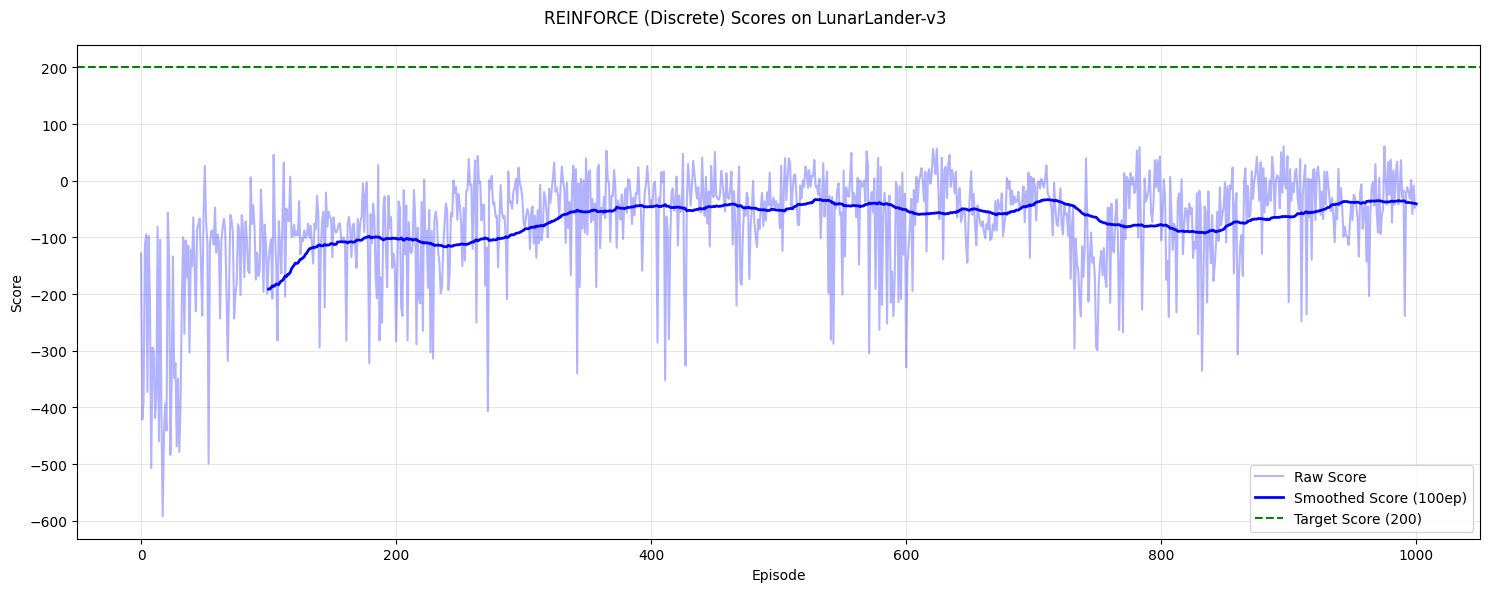

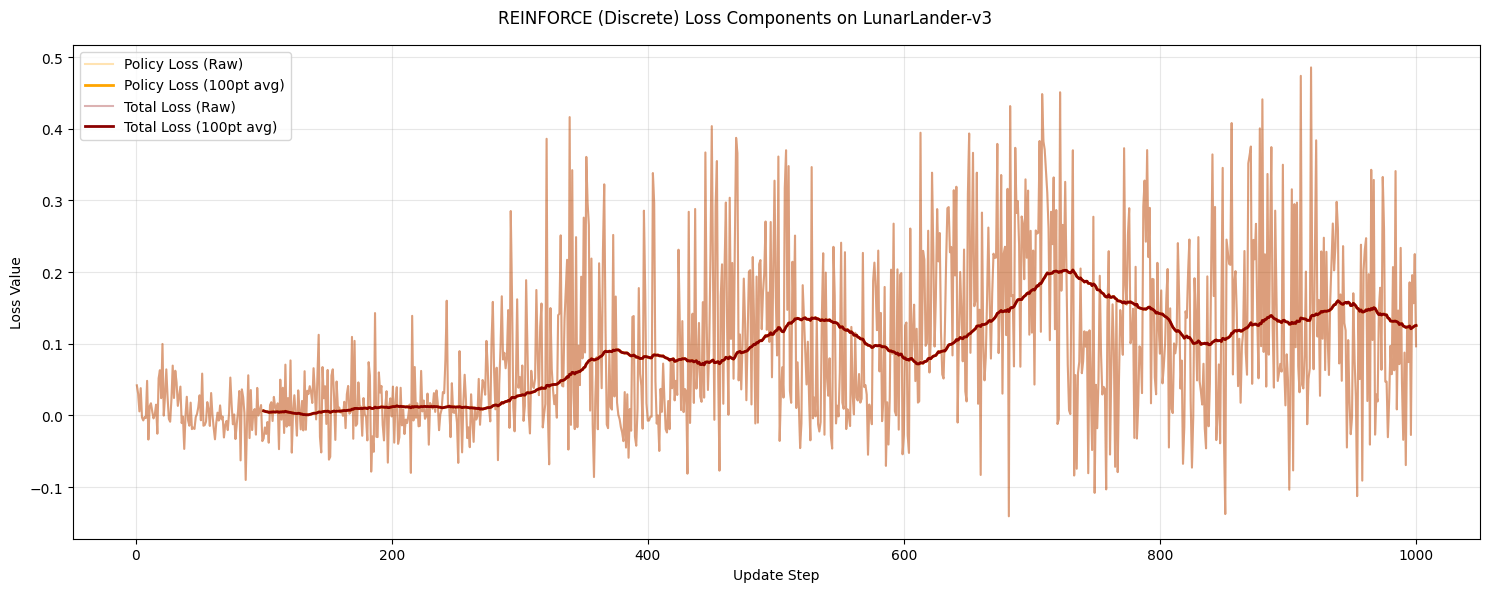

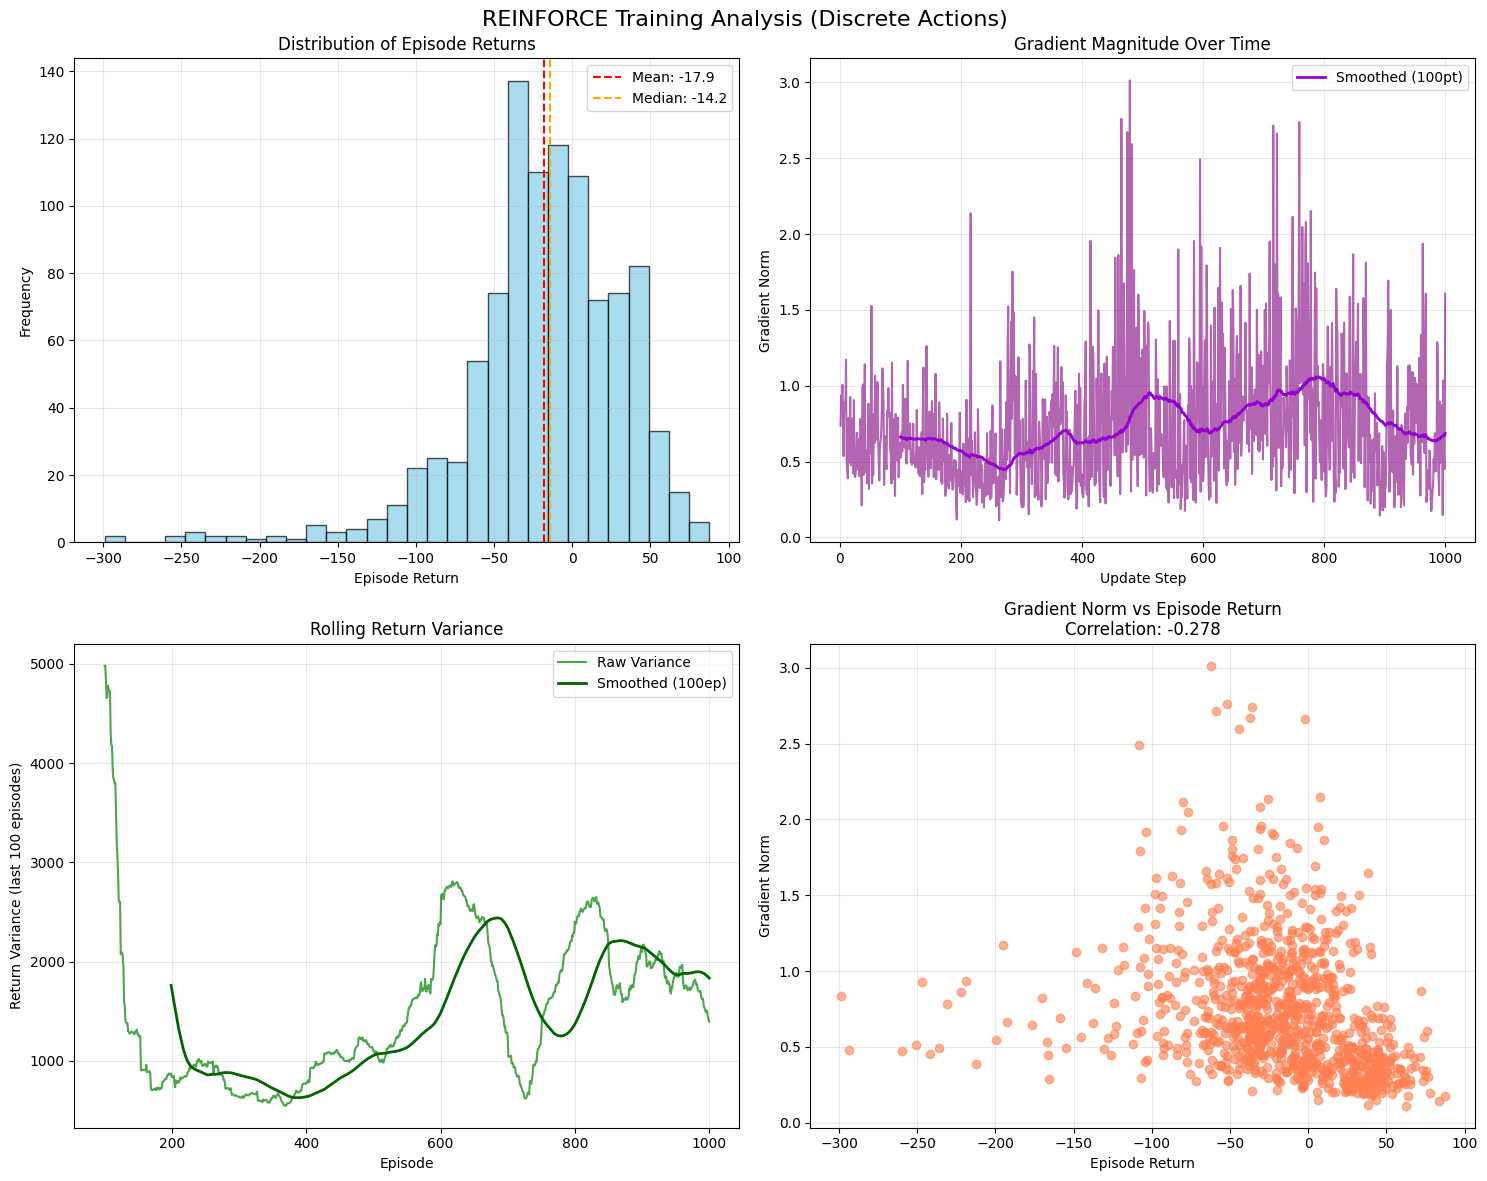


--- REINFORCE Training Statistics (Discrete) ---
Episode Returns: μ=-17.95, σ=50.94
Gradient Norms: μ=0.7363, σ=0.4259
Recent Return Variance: 1394.39
Coefficient of Variation (Returns): 2.84
Total Update Steps: 1000

✅ DISCRETE TRAINING COMPLETED!
Final average score (last 100 episodes): -40.84
Network parameters: 9,540


In [5]:
# Plot training results with REINFORCE-specific analysis
plot_training_results(discrete_scores, discrete_agent.loss_history, CONFIG, "Discrete", algorithm_name="REINFORCE")

# Show variance analysis with REINFORCE-specific commentary
plot_variance_analysis(discrete_agent, discrete_scores, "Discrete", CONFIG, algorithm_name="REINFORCE")

# Training completion message
final_window_size = min(CONFIG["window_length"], len(discrete_scores))
final_avg = np.mean(discrete_scores[-final_window_size:]) if final_window_size > 0 else 0.0
print(f"\n✅ DISCRETE TRAINING COMPLETED!")
print(f"Final average score (last {final_window_size} episodes): {final_avg:.2f}")
print(f"Network parameters: {discrete_agent.policy.get_param_count():,}")


In [6]:
# --- CONTINUOUS ACTION SPACE TRAINING ---
print("Starting REINFORCE training with CONTINUOUS actions...")

continuous_scores, continuous_losses, continuous_agent = train_reinforce(is_continuous=True, config=CONFIG)


📹 Displaying 9 training videos (episodes: [110, 221, 332, 443, 554, 665, 776, 887, 998]):


Ep  999 | Score:   92.6 | Avg(100):   18.3 | PolicyLoss:   0.0655 | TotalLoss:   0.0655 | GradNorm: 0.7865: 100%|█████████▉| 999/1000 [50:44<00:04,  4.58s/episode]

📹 9 training videos available in videos/REINFORCE_continuous


Ep 1000 | Score:  134.3 | Avg(100):   19.2 | PolicyLoss:   0.0111 | TotalLoss:   0.0111 | GradNorm: 0.6615: 100%|██████████| 1000/1000 [50:48<00:00,  3.05s/episode]


Continuous training completed in 3048.9 seconds!
Final performance: 19.19 (last 100 episodes)


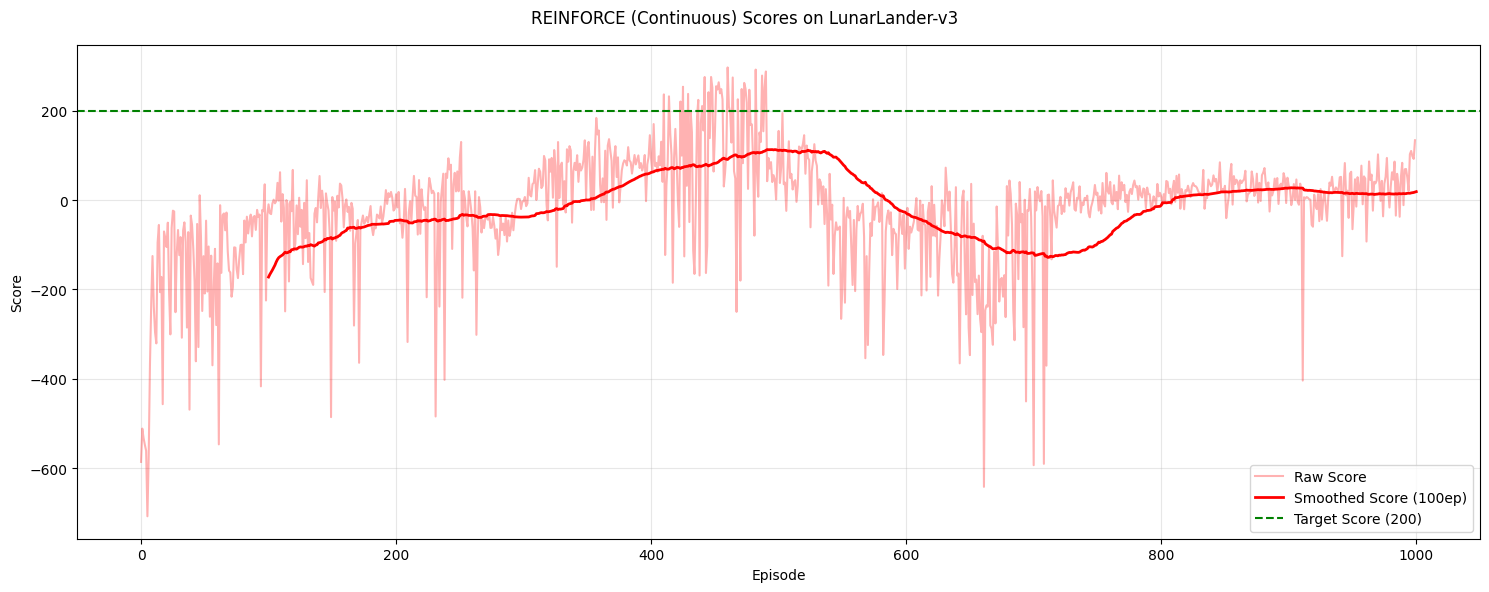

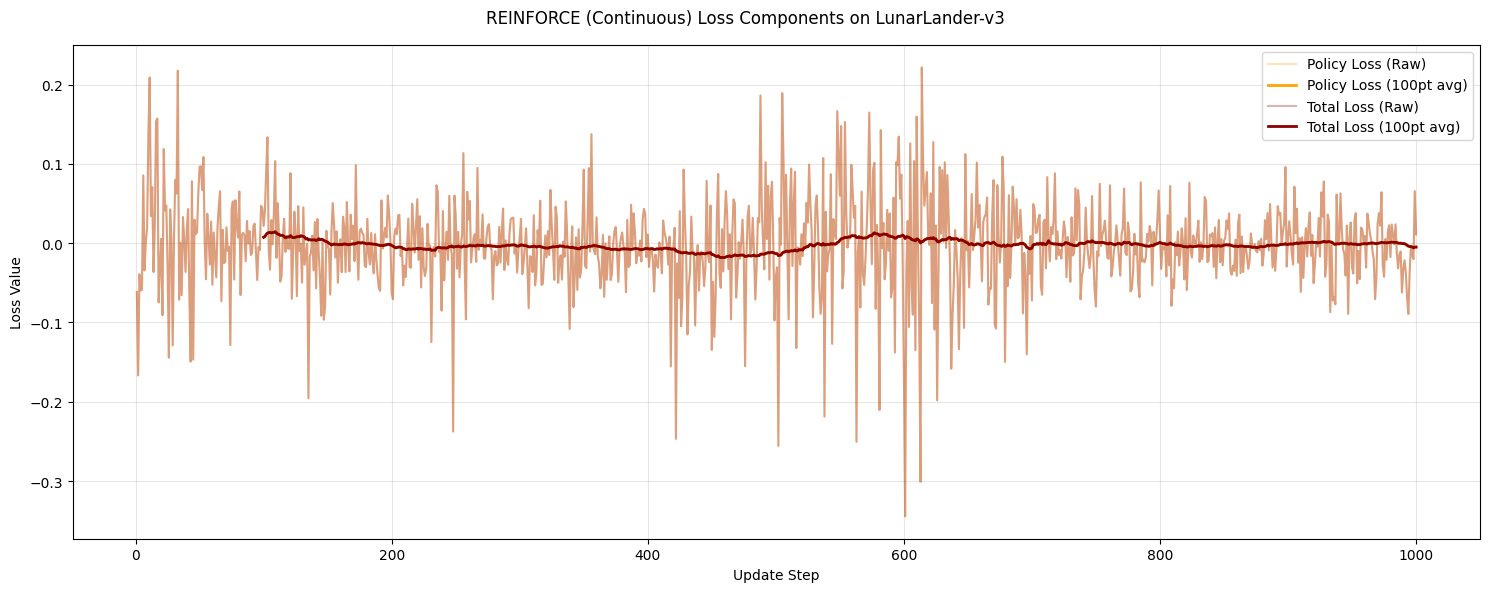

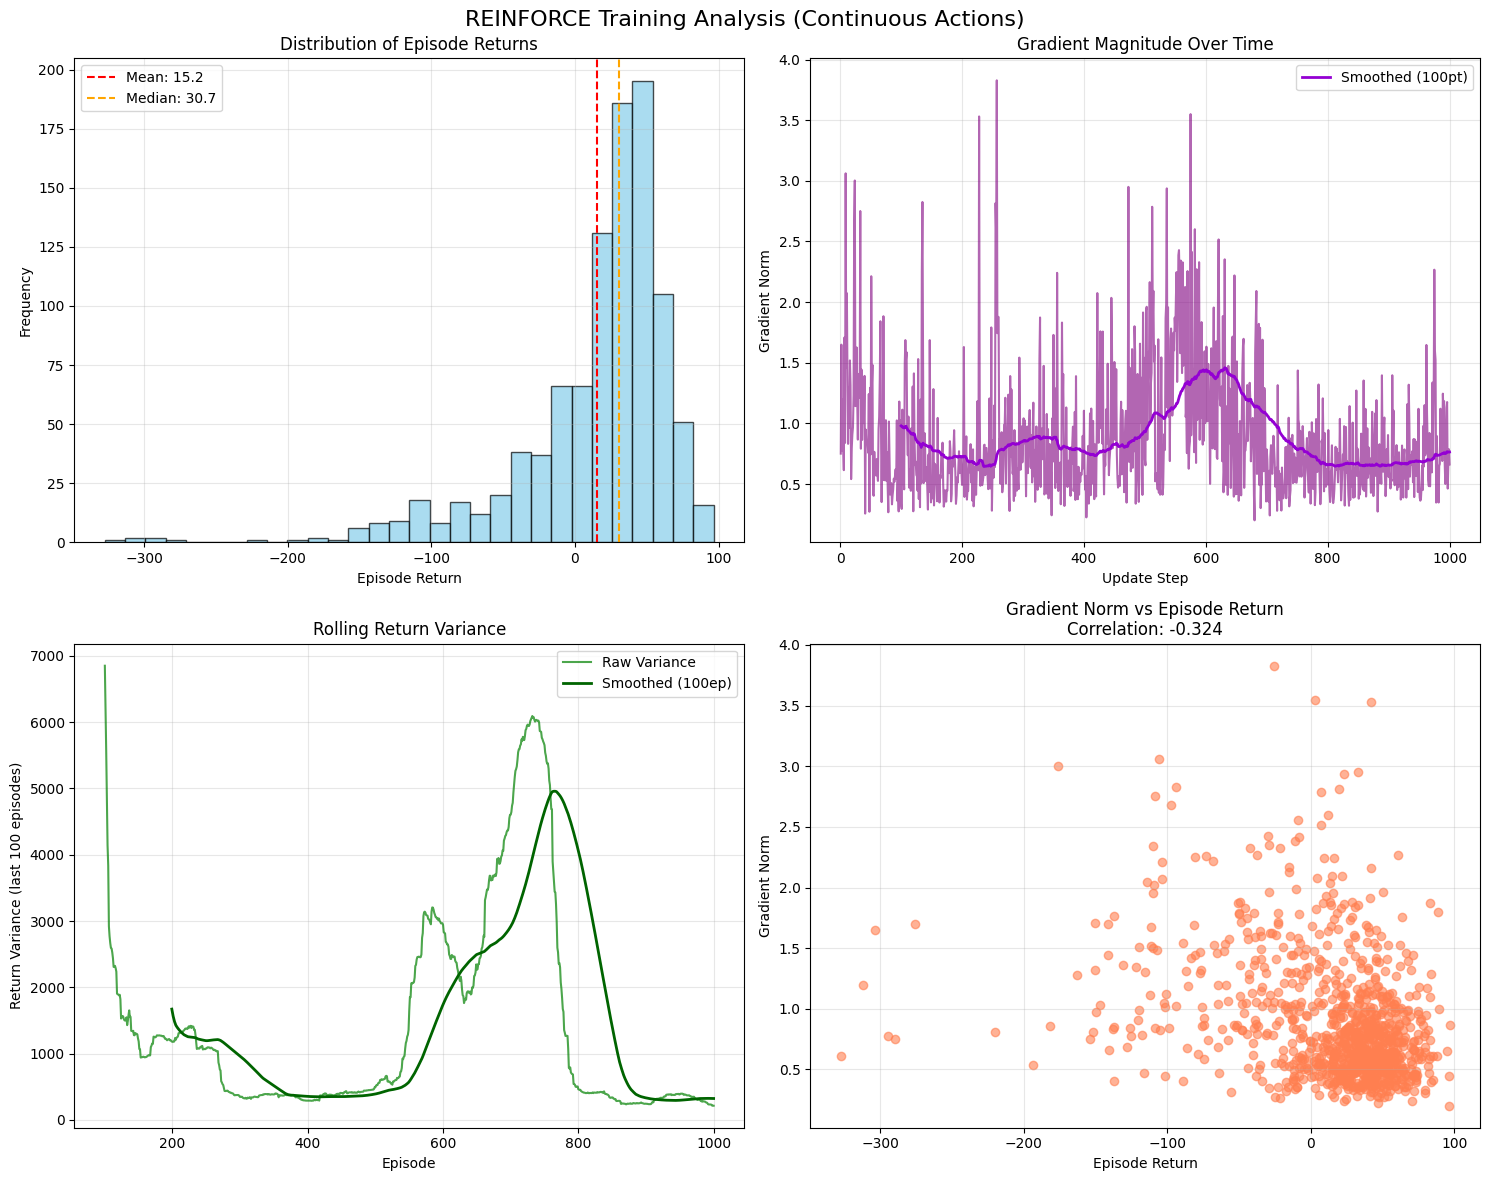


--- REINFORCE Training Statistics (Continuous) ---
Episode Returns: μ=15.20, σ=54.50
Gradient Norms: μ=0.8845, σ=0.5109
Recent Return Variance: 214.98
Coefficient of Variation (Returns): 3.59
Total Update Steps: 1000

✅ CONTINUOUS TRAINING COMPLETED!
Final average score (last 100 episodes): 19.19
Network parameters: 9,412


In [7]:
# Plot training results with REINFORCE-specific analysis
plot_training_results(continuous_scores, continuous_agent.loss_history, CONFIG, "Continuous", algorithm_name="REINFORCE")

# Show variance analysis with REINFORCE-specific commentary
plot_variance_analysis(continuous_agent, continuous_scores, "Continuous", CONFIG, algorithm_name="REINFORCE")

# Training completion message
final_window_size = min(CONFIG["window_length"], len(continuous_scores))
final_avg = np.mean(continuous_scores[-final_window_size:]) if final_window_size > 0 else 0.0
print(f"\n✅ CONTINUOUS TRAINING COMPLETED!")
print(f"Final average score (last {final_window_size} episodes): {final_avg:.2f}")
print(f"Network parameters: {continuous_agent.policy.get_param_count():,}")



COMPARATIVE ANALYSIS: Discrete vs Continuous REINFORCE

📊 NETWORK PARAMETER COMPARISON:
Discrete Policy Network:   9,540 parameters
Continuous Policy Network: 9,412 parameters

Final Performance (last 20 episodes average):
Discrete:   -26.26
Continuous: 56.21

Variance Comparison:
                    Discrete    Continuous
Return StdDev:      50.94        54.50
Gradient StdDev:    0.4259      0.5109


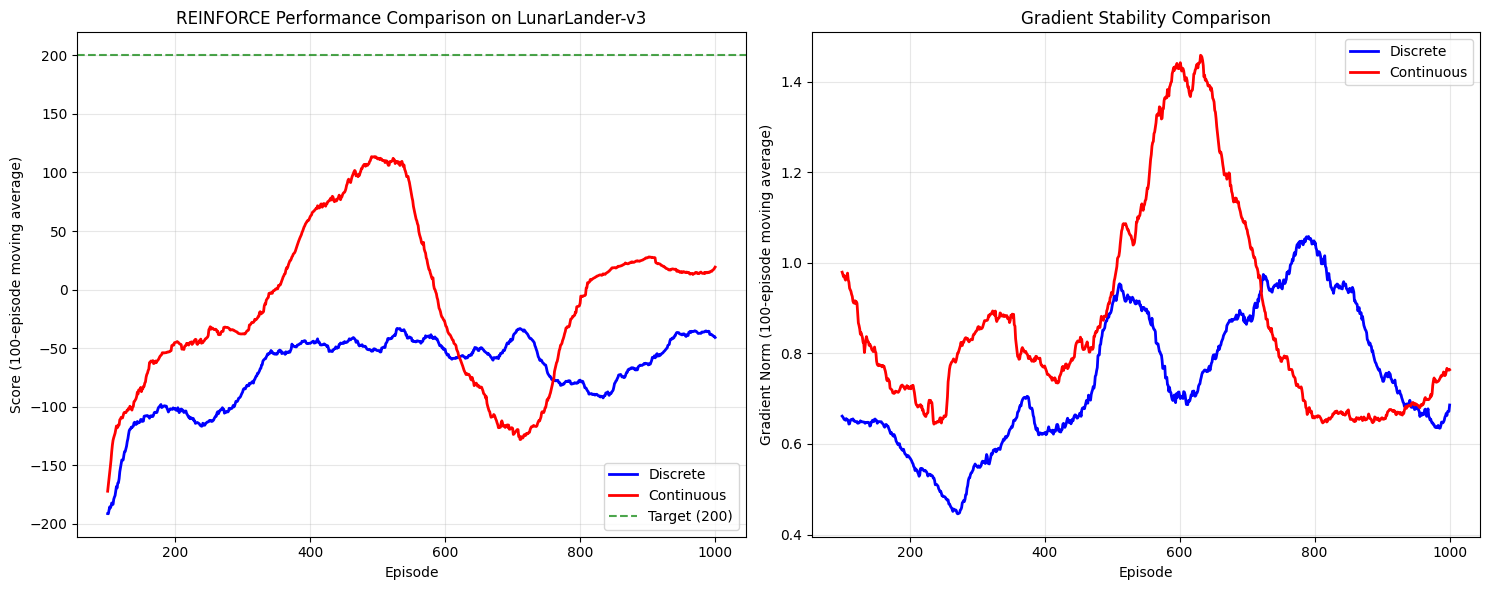

<Figure size 640x480 with 0 Axes>

In [8]:
# --- COMPARATIVE ANALYSIS ---
from rl_utils.visualization import plot_comparison

print(f"\n{'='*60}")
print(f"COMPARATIVE ANALYSIS: Discrete vs Continuous REINFORCE")
print(f"{'='*60}")

# Print parameter counts for comparison
print(f"\n📊 NETWORK PARAMETER COMPARISON:")
print(f"Discrete Policy Network:   {discrete_agent.policy.get_param_count():,} parameters")
print(f"Continuous Policy Network: {continuous_agent.policy.get_param_count():,} parameters")

# Plot comparison with REINFORCE-specific context
plot_comparison(
    discrete_results=(discrete_scores, discrete_agent),
    continuous_results=(continuous_scores, continuous_agent),
    config=CONFIG,
    algorithm_name="REINFORCE"
)